# <font color ='red'> Overal very good effort. First of all, the workflow is very smooth. Strong EDA, handling missing values, discussions, and analysis. The modeling part is also very structural an consistent. For feature selection you use only correlation feature. But correlation only give you features which has a linear relashionships with the price. What if some feature contribute to the price, but they may not have linear relationship. This is the reason why your Lasso, Ridge and LNet do not improve the R2 too much compared to the linear regression. In addition, what is our baseline? How we can compare our models, how good are they compare to baseline?  <br></font>
# <font color ='red'>Regarding the second question. You were asked to make a prediction of residuals, using only renovateble features. The predicted R2 should show us the variance which we can explain using only renovatable features, which we were not able to explain with non-renovatble ones. Then you may take a look on model-coeffisients. For example if we wanted to upgrade a kitchen from "fair" (TA) to "good" (Gd) then we would evaluate the differences in their coefficients. The difference between them is an estimate of how much value we would gain making that change. So you were not asked to combine two models.
</font>

<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

<font color = red> Note: more EDAs charts are created in another workbook. kept it in separate workbook to avoid cluttering this workbook</font>

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---


In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Load the data
house = pd.read_csv('./housing.csv')
house.head()

# code to read all columns

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

### <font color = orange> EDA & Data Processing</font>

In [2]:
house.shape

(1460, 81)

In [3]:
# checking the data types to see if any columns need type conversion
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [4]:
# Check average saleprice for different properties type

house.groupby('MSZoning').agg([np.size,np.mean])['SalePrice']

size           mean
MSZoning                     
C (all)     10   74528.000000
FV          65  214014.061538
RH          16  131558.375000
RL        1151  191004.994787
RM         218  126316.830275

In [5]:
# Drop non-residential --> C(all) Commercial

house.drop(house[house['MSZoning'] == 'C (all)'].index,inplace=True)

In [6]:
# Check missing values percentage

missing_value =  pd.DataFrame(house.isnull().sum()).reset_index().rename(columns={'index':'variable',
                              0:'missing_value',}).sort_values(by='missing_value',ascending=False)
missing_value['missing_percentage'] = missing_value['missing_value'] / 1460
missing_value[missing_value['missing_value']>0]

# POOLQC has 1443 missing values which comprises 99% of the data.

variable  missing_value  missing_percentage
72        PoolQC           1443            0.988356
74   MiscFeature           1398            0.957534
6          Alley           1361            0.932192
73         Fence           1172            0.802740
57   FireplaceQu            681            0.466438
3    LotFrontage            259            0.177397
59   GarageYrBlt             79            0.054110
64    GarageCond             79            0.054110
58    GarageType             79            0.054110
60  GarageFinish             79            0.054110
63    GarageQual             79            0.054110
35  BsmtFinType2             38            0.026027
32  BsmtExposure             38            0.026027
30      BsmtQual             37            0.025342
31      BsmtCond             37            0.025342
33  BsmtFinType1             37            0.025342
26    MasVnrArea              8            0.005479
25    MasVnrType              8            0.005479
42    Electrical              1            0.000685

In [7]:
# Drop columns with >80% missing values ['PoolQC','MiscFeature','Alley','Fence']

column_to_drop =  ['PoolQC','MiscFeature','Alley','Fence']
house.drop(columns = column_to_drop , inplace=True)
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodD

In [8]:
# Drop sale related columns as well as we are assuming that we are predicting for un-sold houses which do not have 
# these informations

sale_related_col =  ['SaleType','SaleCondition','MoSold']
house.drop(columns = sale_related_col , inplace=True)
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodD

In [9]:
# Manually cleaning up missing values for certain columns

house.BsmtExposure.replace({'No':1,'Mn':2,'Av':3,'Gd':4},inplace=True)
# fill NA with 0 as it means the house has no basement
house['BsmtExposure'] = house['BsmtExposure'].fillna(0)

house.CentralAir.replace({'Y':1,'N':0},inplace=True)

# Converting MSSubClass to categorical data
house['MSSubClass'] = house['MSSubClass'].map(lambda x: str(x))
house['LotFrontage'] = house['LotFrontage'].fillna(np.mean(house['LotFrontage']))

# there are only 7 null values with MasVnrArea - replace it with 0 which is the mod
house['MasVnrArea'] = house['BsmtExposure'].fillna(0)

In [10]:
# calculate age of the house at the point of sold
house['house_age'] =  house['YrSold'] - house['YearBuilt']

# calculate age of garage
house['garage_age'] = house['YrSold'] - house['GarageYrBlt']
house['garage_age'] = house['garage_age'].fillna(np.mean(house['garage_age']))

# remodal date
house['remod_years'] = house['YrSold'] - house['YearRemodAdd']

In [11]:
# Check data type for columns with missing values
for col in missing_value[missing_value['missing_value']>0]['variable'][4:]:
    for val in house.columns:
        if val == col:
            print(val, house[val].dtype)

FireplaceQu object
LotFrontage float64
GarageYrBlt float64
GarageCond object
GarageType object
GarageFinish object
GarageQual object
BsmtFinType2 object
BsmtExposure float64
BsmtQual object
BsmtCond object
BsmtFinType1 object
MasVnrArea float64
MasVnrType object
Electrical object


In [12]:
# Programmatically cleaning up missing for the rest of the columns based on their data type

for col in missing_value[missing_value['missing_value']>0]['variable'][4:]:
    for val in house.columns:
        
# For all categorical data, fill missing values with NA
        if val == col and house[val].dtype == 'object':
            house[val] = house[val].fillna('NA')
            
# For numeric data, fill missing values with median
        elif val == col and house[val].dtype == 'float64':
            house[val] = house[val].fillna(np.median(house[val]))


C:\Users\swoo\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


In [13]:
# Identify categorical columns with low variance

for val in list(house.select_dtypes(include=['object']).columns):
         print(house.groupby(val).size())
# Street, Utilities,Condition2,'RoofMatl',Heating

MSSubClass
120     87
160     63
180     10
190     29
20     534
30      67
40       4
45      12
50     140
60     299
70      59
75      16
80      58
85      20
90      52
dtype: int64
MSZoning
FV      65
RH      16
RL    1151
RM     218
dtype: int64
Street
Grvl       4
Pave    1446
dtype: int64
LotShape
IR1    483
IR2     41
IR3     10
Reg    916
dtype: int64
LandContour
Bnk      62
HLS      49
Low      34
Lvl    1305
dtype: int64
Utilities
AllPub    1449
NoSeWa       1
dtype: int64
LotConfig
Corner      261
CulDSac      94
FR2          47
FR3           4
Inside     1044
dtype: int64
LandSlope
Gtl    1375
Mod      62
Sev      13
dtype: int64
Neighborhood
Blmngtn     17
Blueste      2
BrDale      16
BrkSide     58
ClearCr     28
CollgCr    150
Crawfor     51
Edwards    100
Gilbert     79
IDOTRR      28
MeadowV     17
Mitchel     49
NAmes      225
NPkVill      9
NWAmes      73
NoRidge     41
NridgHt     77
OldTown    112
SWISU       25
Sawyer      74
SawyerW     59
Somerst     86
St

In [14]:
# Identify numeric columns with low variance

low_variance_col = ['Street', 'Utilities','Condition2','RoofMatl','Heating']
for val in list(house.iloc[:,1:].select_dtypes(include=['int64']).columns):

    # Check if the 10th percentile == 90th percentile  
    
    if (np.percentile(house[val],10) == np.median(house[val])) and (np.median(house[val]) == np.percentile(house[val],90)):
        print(val,np.median(house[val]))
        low_variance_col.append(val)
        
# CentralAir,LowQualFinSF,BsmtHalfBath,KitchenAbvGr,3SsnPorch,ScreenPorch,PoolArea,MiscVal 

CentralAir 1.0
LowQualFinSF 0.0
BsmtHalfBath 0.0
KitchenAbvGr 1.0
3SsnPorch 0.0
ScreenPorch 0.0
PoolArea 0.0
MiscVal 0.0


In [15]:
# Drop columns that have low variance

house.drop(columns = low_variance_col , inplace=True)
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'YrSold',
       'SalePrice', 'house_age', 'garage_age', 'remod_years'],
      dtype='object')

In [16]:
# Final check for missing values

missing_value =  pd.DataFrame(house.isnull().sum()).reset_index().rename(columns={'index':'variable',
                              0:'missing_value',}).sort_values(by='missing_value',ascending=False)
missing_value['missing_percentage'] = missing_value['missing_value'] / house.shape[0]
missing_value[missing_value['missing_value']>0]

variable  missing_value  missing_percentage
49  GarageYrBlt             79            0.054483

In [17]:
# Selected fixed characteristics for a house

fixed = ['MSSubClass',
        'MSZoning',
        'LotFrontage',
        'LotArea',
        'LotShape',
        'LandContour',
        'LotConfig',
        'LandSlope',
        'Neighborhood',
        'Condition1',
        'BldgType',
        'HouseStyle',   
        'MasVnrArea',
        'BsmtExposure',
        'BsmtFinType1',
        'BsmtFinSF1',
        'BsmtFinType2',
        'BsmtFinSF2',
        'BsmtUnfSF',
        'TotalBsmtSF',
        '1stFlrSF',
        '2ndFlrSF',
        'GrLivArea',
        'BsmtFullBath',
        'FullBath',
        'HalfBath',
        'BedroomAbvGr',
        'TotRmsAbvGrd',
        'Fireplaces',
        'GarageType',
        'GarageCars',
        'GarageArea',
        'PavedDrive',
        'WoodDeckSF',
        'OpenPorchSF',
        'EnclosedPorch',
        'house_age',
        'garage_age',
        'remod_years' 
        ]

### <font color = orange> Train test data split </font>

In [18]:
house_train = house[house['YrSold'].astype('int64')<2010]
house_test = house[house['YrSold'].astype('int64')==2010]
house_train.shape, house_test.shape

((1278, 64), (172, 64))

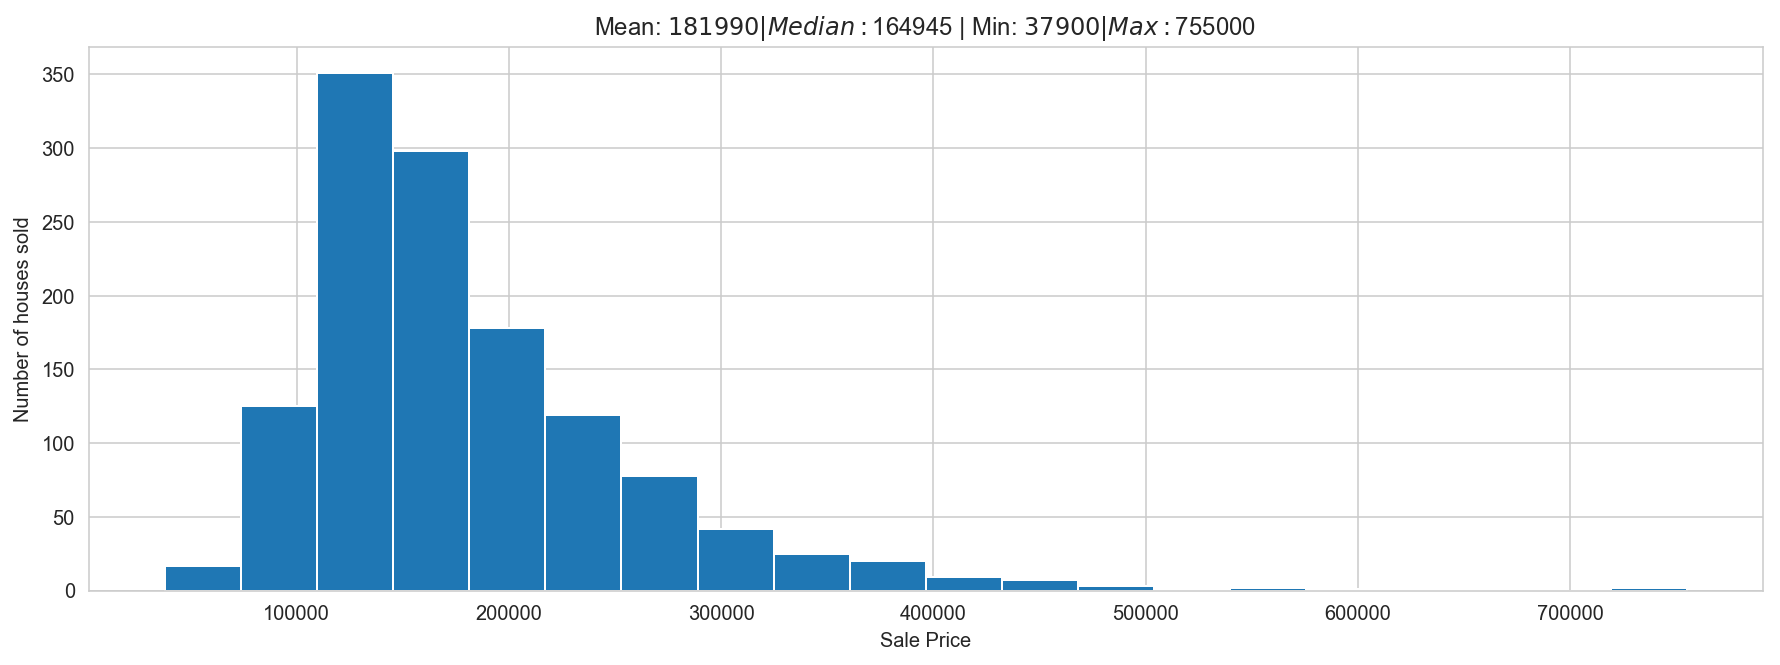

In [19]:
# Take a look at the sales price for training data

plt.figure(figsize=(15,5))
plt.hist(house_train['SalePrice'],bins=20)
plt.xlabel('Sale Price')
plt.ylabel('Number of houses sold');
title = "Mean: ${:.0f} | Median: ${:.0f} | Min: ${:.0f} | Max: ${:.0f} "\
        .format(np.mean(house_train['SalePrice']),np.median(house_train['SalePrice'])\
                ,np.min(house_train['SalePrice']),np.max(house_train['SalePrice']))
plt.title(title);

<p> <font color = blue> Sales price distribution is skewed to the right, with a few outliers. 
    
 </font></p>

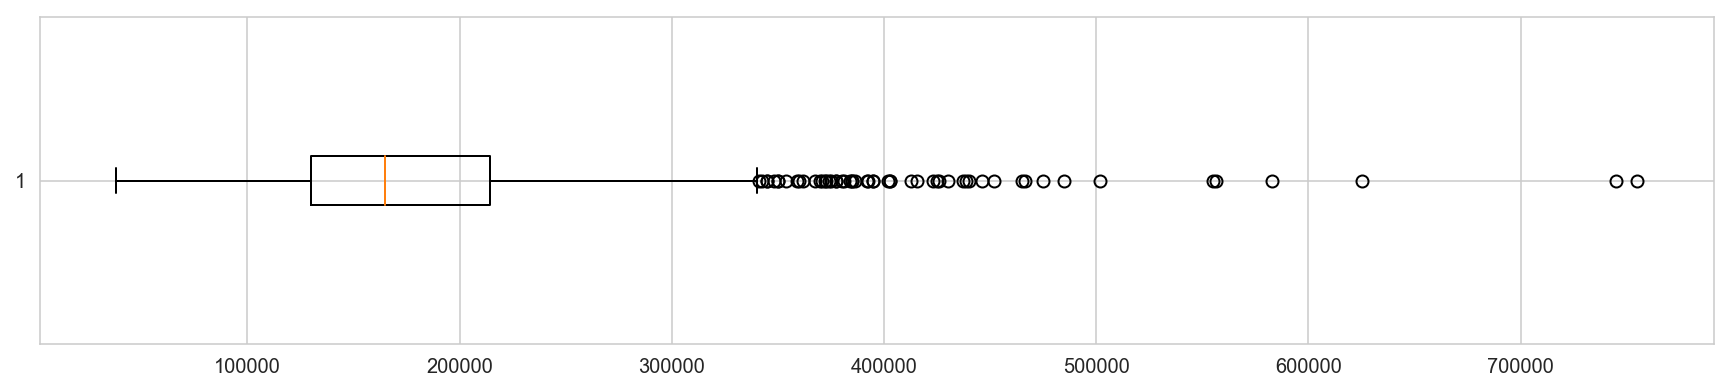

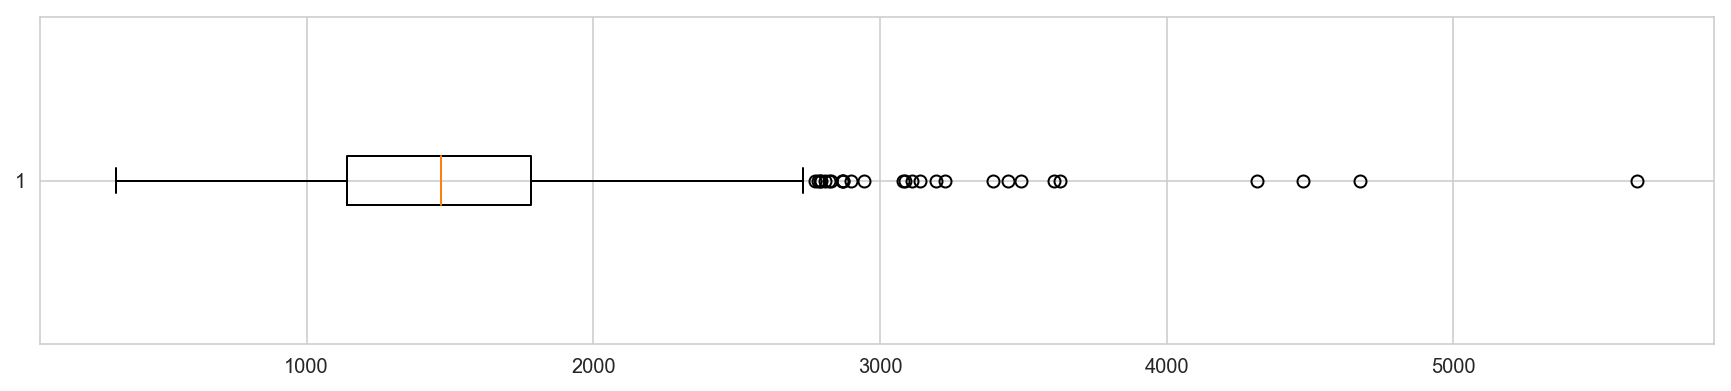

In [20]:
# Using boxplot to gauge the outliers

plt.figure(figsize=(15,3))
plt.boxplot(house_train['SalePrice'],vert=False)
plt.show()

plt.figure(figsize=(15,3))
plt.boxplot(house_train['GrLivArea'],vert=False)
plt.show()

In [21]:
# TAGGING OUTLIERS USING:

# IQR
Q1 = house_train['SalePrice'].quantile(0.25)
Q3 = house_train['SalePrice'].quantile(0.75)
IQR = Q3 - Q1
# IQR = 84000

lower = Q1 - 1.5*IQR
upper = Q1 + 1.5*IQR

house_train['outlier_iqr'] = [1 if ( val < lower) or (val > upper) else 0 for val in house_train['SalePrice']]

# Z-SCORE

# z = np.abs(stats.zscore(house['SalePrice']))
# print(z)

C:\Users\swoo\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


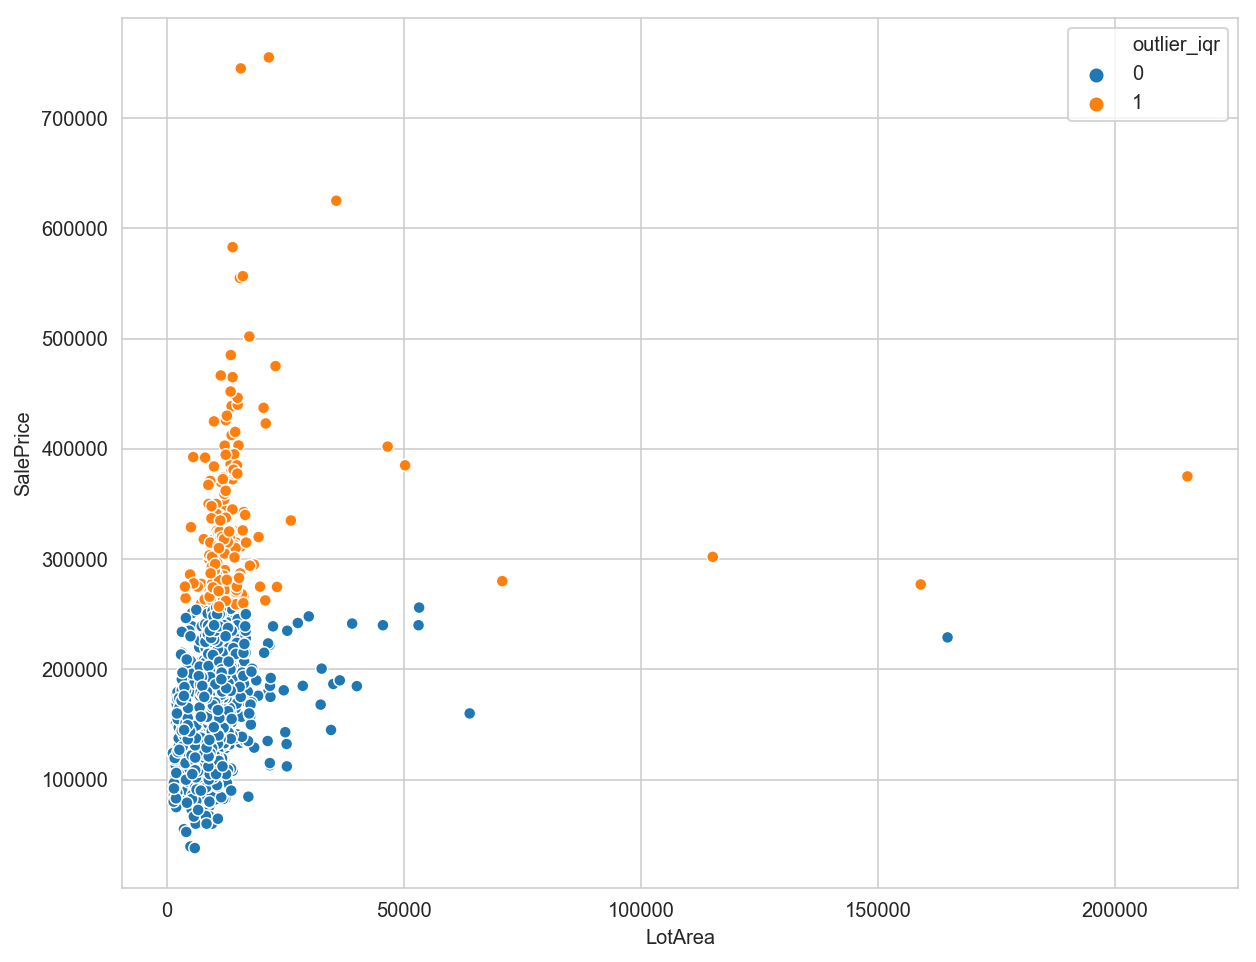

In [22]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=house_train,x='LotArea',y='SalePrice',hue='outlier_iqr');

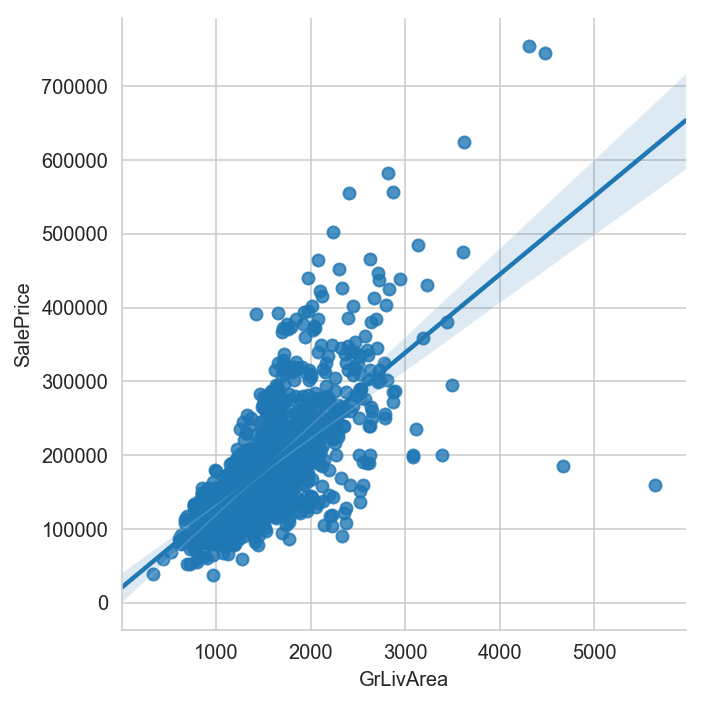

In [23]:
sns.lmplot(data=house_train,x='GrLivArea',y='SalePrice');

#### <font color = blue> Ground Living Area has a stronger correlation with Sales Price as compared to Lot Area.
</font>

In [24]:
# Investigate correlation for size / area related features
# A function to create heat_map

def correlation_heat_map(df):
    corrs = df.corr()

    fig, ax = plt.subplots(figsize=(13,9))

    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    ax = sns.heatmap(corrs, mask=mask, annot=True)

    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    plt.show()

In fact, from the correlation matrix, we see that GrLivArea, GarageArea,TotalBasmtSF and 1stFlrSF are the highest correlated features with SalePrice.

In [25]:
num_col = list(house_train.select_dtypes(include=['int64','float64']).columns)
num_col.remove('Id')
cat_col = list(house_train.select_dtypes(include=['object']).columns)
# correlation_heat_map(house_train['num_col'])

In [26]:
# Variable that has the highest correlation with Saleprice

price_corr = pd.DataFrame(house_train[num_col].corr().sort_values('SalePrice',ascending=True)['SalePrice']).reset_index()
price_corr.columns = ['variable','corr']
price_corr['abs_corr'] = np.abs(price_corr['corr'])
price_corr.sort_values(by='abs_corr',ascending=False).reset_index(inplace=False).head(15)

index      variable      corr  abs_corr
0      32     SalePrice  1.000000  1.000000
1      31   OverallQual  0.790237  0.790237
2      30   outlier_iqr  0.766665  0.766665
3      29     GrLivArea  0.708210  0.708210
4      28    GarageCars  0.642056  0.642056
5      27    GarageArea  0.631140  0.631140
6      26   TotalBsmtSF  0.603704  0.603704
7      25      1stFlrSF  0.598437  0.598437
8      24      FullBath  0.562608  0.562608
9      23  TotRmsAbvGrd  0.528721  0.528721
10      0     house_age -0.512399  0.512399
11     22     YearBuilt  0.512107  0.512107
12      1   remod_years -0.507710  0.507710
13     21  YearRemodAdd  0.505833  0.505833
14     20   GarageYrBlt  0.483080  0.483080

In [27]:
corr_selected_feature = list(price_corr[price_corr['abs_corr']>0.2].variable)
corr_selected_feature = [col for col in corr_selected_feature \
                         if col not in ['SalePrice','OverallQual','outlier_iqr','GarageYrBlt','YearBuilt','YearRemodAdd'] ]
corr_selected_feature

['house_age',
 'remod_years',
 'garage_age',
 'BsmtUnfSF',
 'BsmtFullBath',
 'LotArea',
 'HalfBath',
 '2ndFlrSF',
 'WoodDeckSF',
 'OpenPorchSF',
 'LotFrontage',
 'BsmtFinSF1',
 'BsmtExposure',
 'MasVnrArea',
 'Fireplaces',
 'TotRmsAbvGrd',
 'FullBath',
 '1stFlrSF',
 'TotalBsmtSF',
 'GarageArea',
 'GarageCars',
 'GrLivArea']

# Models

In [28]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [29]:
fixed_cat_col = list(house_train[fixed].select_dtypes(include = 'object').columns)

###  <font color=orange>Standardize X_train, y_train</font> 

In [30]:
# From the list of selected fixed characteristics, use only 
# fixed_cat_col : categorical columns
# corr_selected_feature : numerical columns that have more than 0.2 correlation with saleprice

X_train = house_train[fixed_cat_col + corr_selected_feature]
y_train = pd.DataFrame(house_train['SalePrice'])

Xd_train = pd.get_dummies(X_train[fixed_cat_col],drop_first=True)
ss = StandardScaler()
Xs_train = pd.DataFrame(ss.fit_transform(X_train[corr_selected_feature]))
Xs_train.columns = corr_selected_feature
X_train_final = Xs_train.merge(Xd_train.reset_index()
                               ,how='left',left_on = None
                               , right_on = None
                               , left_index = True
                               , right_index = True)


C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


###  <font color=orange>Linear Regression</font>


In [31]:
linreg = LinearRegression()
linreg.fit(X_train_final,np.ravel(y_train))
linreg_scores = cross_val_score(linreg, X_train_final,np.ravel(y_train),cv=5)
print(linreg_scores)
print(np.mean(linreg_scores))

[0.84277662 0.79154622 0.81893362 0.79900333 0.64192423]
0.7788368037244122


###  <font color=orange>Ridge Regression</font>

In [32]:
ridge_alphas = np.logspace(-2, 7, 50)
ridge = RidgeCV(alphas=ridge_alphas, cv=10)
ridge_scores = cross_val_score(ridge, X_train_final,y_train,cv=5)
ridge.fit(X_train_final,np.ravel(y_train))
print(ridge_scores)
print(np.mean(ridge_scores))
print(ridge.alpha_)

C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[0.86178436 0.80515591 0.82287925 0.81508633 0.64725047]
0.7904312638732715
8.685113737513529


C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


###  <font color=orange>Lasso Regression</font>

In [33]:
lasso = LassoCV(cv=5)
lasso.fit(X_train_final,y_train)
lasso_scores = cross_val_score(lasso,X_train_final,y_train,cv=5)
print(lasso_scores)
print(np.mean(lasso_scores))

C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array w

[0.82571052 0.78605434 0.77075035 0.79297588 0.5644235 ]
0.7479829179290678


C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


###  <font color = orange> Enet </font>

In [34]:
l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, 
                            n_alphas=30, 
                            cv=10, 
                            max_iter=10000)

optimal_enet.fit(X_train_final, y_train)

enet = ElasticNet(alpha=optimal_enet.alpha_, 
                  l1_ratio=optimal_enet.l1_ratio_)

enet.fit(X_train_final,y_train)

enet_scores = cross_val_score(enet, X_train_final, y_train, cv=10)

print(enet_scores)
print(np.mean(enet_scores))

C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0.84389389 0.80240165 0.83866696 0.72480331 0.76060525 0.78592024
 0.82128451 0.74714193 0.40848506 0.83753728]
0.7570740093099187


## <font color=green>Final model R2 Scores
Ridge  has the highest R2 score than Lasso, Linear and Enet.  
    - MODEL 1: price ~ fixed_characteristics 
            - Linear | 0.77
            - Ridge | 0.79
            - Lasso | 0.75
            - Enet  | 0.76


### Compare coefficients of Lasso and Ridge models

#### <font color = orange> Lasso Model Coefficients </font>

In [35]:
lasso_coefs = pd.DataFrame({'variable':X_train_final.columns,'coef':lasso.coef_,'abs_coef':np.abs(lasso.coef_)})
lasso_coefs[lasso_coefs['abs_coef']>0].sort_values('abs_coef',ascending=False).head(10)

variable          coef      abs_coef
21             GrLivArea  33546.439394  33546.439394
67  Neighborhood_NridgHt  25570.507030  25570.507030
20            GarageCars  10975.572139  10975.572139
96      BsmtFinType1_GLQ  10096.628216  10096.628216
1            remod_years  -9461.880689   9461.880689
0              house_age  -8502.792070   8502.792070
18           TotalBsmtSF   7782.662108   7782.662108
12          BsmtExposure   7267.591608   7267.591608
14            Fireplaces   7237.636567   7237.636567
26         MSSubClass_20   5545.476257   5545.476257

#### <font color = orange> Ridge Model Coefficients </font>

In [36]:
ridge_coefs = pd.DataFrame({'variable':X_train_final.columns,'coef':ridge.coef_,'abs_coef':np.abs(ridge.coef_)})
ridge_coefs[ridge_coefs['abs_coef']>0].sort_values('abs_coef',ascending=False).head(10)

variable          coef      abs_coef
67  Neighborhood_NridgHt  47154.055692  47154.055692
73  Neighborhood_StoneBr  41066.895373  41066.895373
66  Neighborhood_NoRidge  33681.147150  33681.147150
62  Neighborhood_Mitchel -19472.279588  19472.279588
21             GrLivArea  19228.540597  19228.540597
58  Neighborhood_Edwards -18388.606120  18388.606120
41          LotShape_IR3 -17454.869831  17454.869831
86        BldgType_Twnhs -16673.255049  16673.255049
59  Neighborhood_Gilbert -16319.252908  16319.252908
7               2ndFlrSF  15962.959326  15962.959326

In [37]:
house_train['GrLivArea'].describe()

count    1278.000000
mean     1521.956182
std       528.257430
min       334.000000
25%      1140.250000
50%      1469.500000
75%      1782.750000
max      5642.000000
Name: GrLivArea, dtype: float64

## Which are the best estimates of price?

#### Top 10 most significant coefficients:

- Neighborhood 
        NridgHt, StoneBr, NoRidge : positive impact on price
                Example: Property value in NridgHt is 47k higher as compared to the average price across all neighborhood.
        Mitchel, Edwards, Gilbert : negative impact on price
                Example: Property value in NridgHt is 18k lower as compared to the average price across all neighborhood.

- Property size:
        Ground Living Area
                Example: For an increase of 1000sqft in ground living area, we see an average increase of $36,399 in value.
        2nd Floor Squarefeet

- Building Type - Twinhouse
   

## Lasso → Test on 2010 data

#### <font color = orange> Transform X_test data </font>

In [38]:
X_test = house_test[fixed_cat_col + corr_selected_feature]
y_test = house_test['SalePrice']

Xd_test = pd.get_dummies(X_test[fixed_cat_col],drop_first=True)
Xs_test = pd.DataFrame(ss.transform(X_test[corr_selected_feature]))
Xs_test.columns = corr_selected_feature
X_test_final = Xs_test.merge(Xd_test.reset_index()
                             ,how='left'
                             ,left_on = None
                             ,right_on = None
                             ,left_index = True
                             ,right_index = True)


C:\Users\swoo\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


In [39]:
# Get missing columns in the test
missing_cols = set( X_train_final.columns ) - set( X_test_final.columns )

# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    X_test_final[c] = 0
    
# Ensure the order of column in the test set is in the same order than in train set
X_test_final = X_test_final[X_train_final.columns]

In [40]:
print("Lasso R2 score is {:.2f}".format(lasso.score(X_test_final,y_test)))
print("Ridge R2 score is {:.2f}".format(ridge.score(X_test_final,y_test)))

Lasso R2 score is 0.80
Ridge R2 score is 0.85


## <font color = green> Final model selected - Ridge </font>

<br> Ridge gives an average R2 score of 0.79 on training data set. When tested on test data, the R2 score is 0.85.</br>
<br> R-squared - a statistical measure of how close the data are to the fitted line. </br>
<br> Key limitations of R-squared: It can't determine whether the coefficient estiamtes and predictions are biased. In order to do that, we can look at our residual plot:</br>
</font>

#### <font color = orange> Visualizing actual sale price and predicted price </font>

C:\Users\swoo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\swoo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


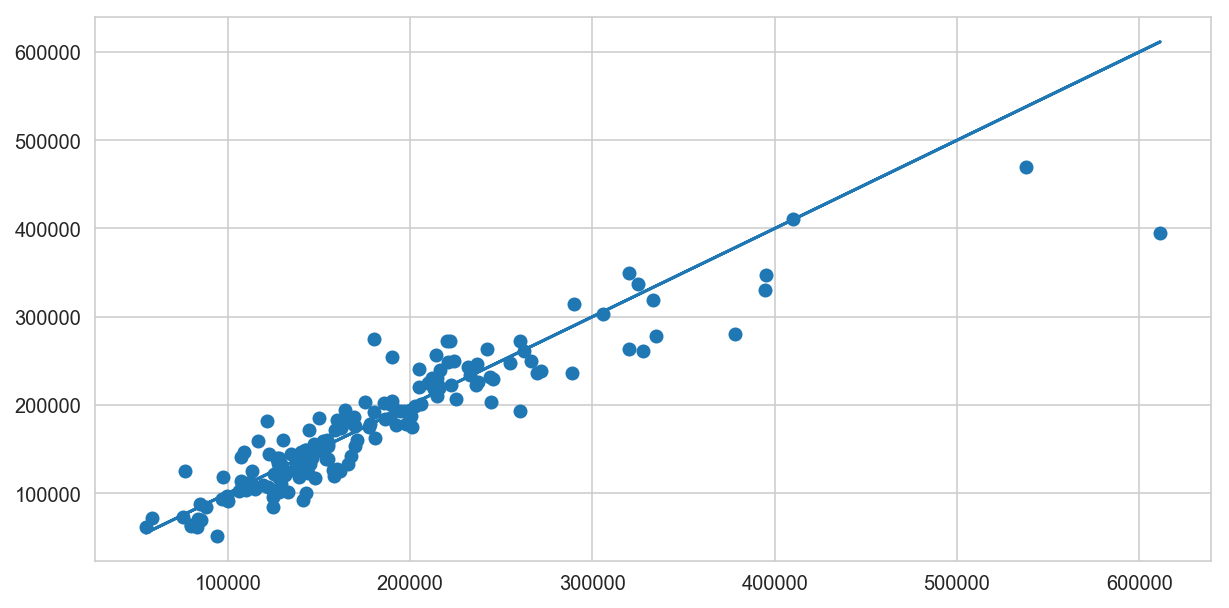

In [41]:
house_train['price_predict'] = list(ridge.predict(X_train_final))
house_test['price_predict'] = list(ridge.predict(X_test_final))

plt.figure(figsize=(10,5))
plt.scatter(y_test,house_test['price_predict'])
plt.plot(y_test,y_test);

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

### <font color = grey> What are the costs/benefits of quality, condition, and renovations? </font>

#### <font color = orange> Calculating residuals </font>

In [42]:
house_train['residual'] = house_train['price_predict'] - house_train['SalePrice']
house_test['residual'] = house_test['price_predict'] - house_test['SalePrice']

C:\Users\swoo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\swoo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


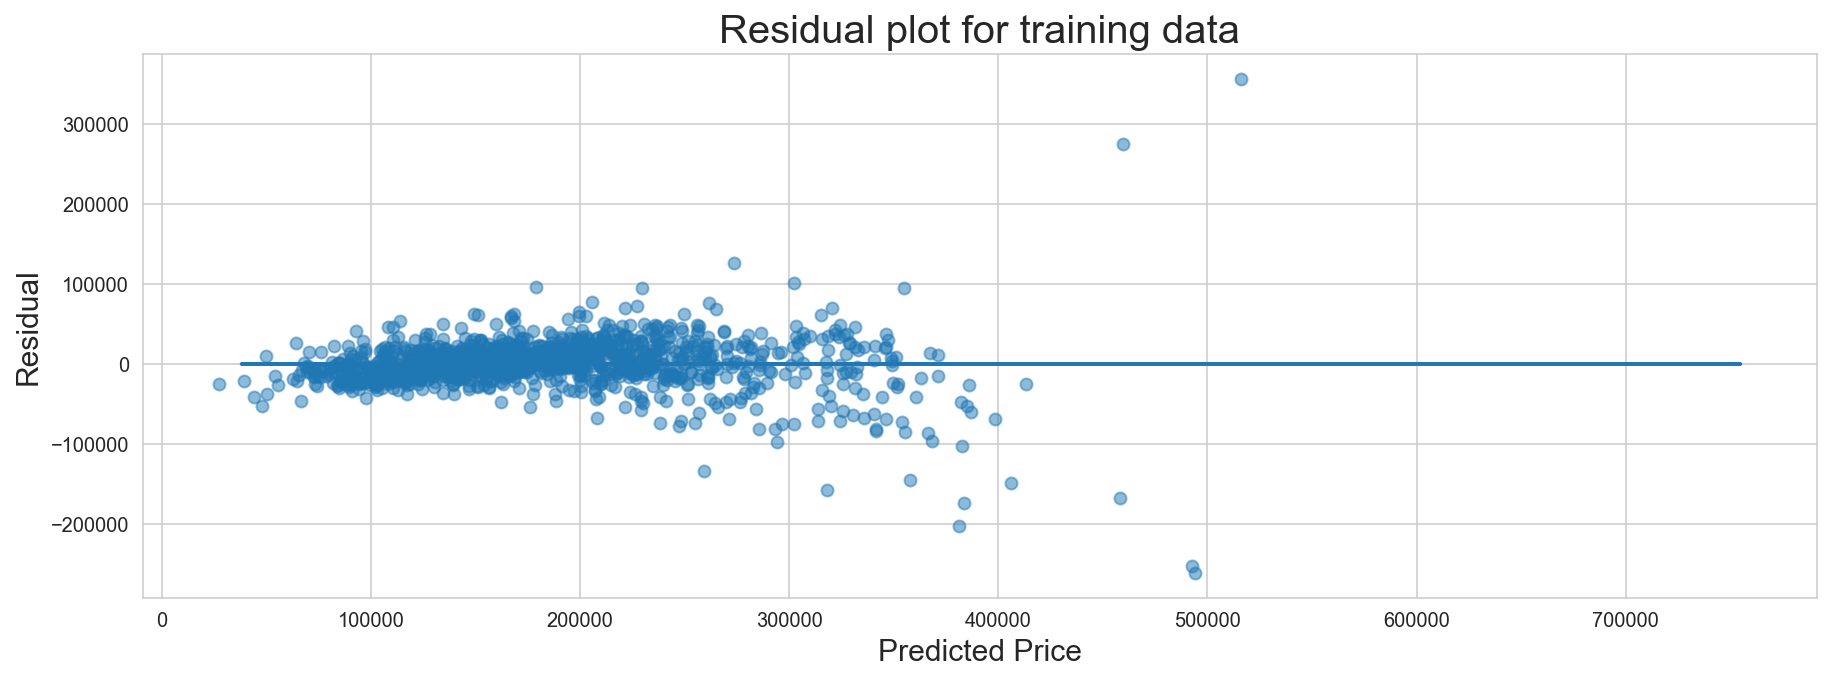

In [43]:
plt.figure(figsize=(15,5))
plt.scatter(house_train['price_predict'],house_train['residual'],alpha=0.5)
plt.plot(house_train['SalePrice'],[0 for val in house_train['SalePrice']])
plt.xlabel('Predicted Price', fontsize=15)
plt.ylabel('Residual', fontsize=15)
plt.title('Residual plot for training data', fontsize=20);

#### <font color=green> Residual plot for training data: </font>

Looking at the residual plot above, it seems that there is a cone shape with the distribution. The magnitude of residual increases as the fitted price increases.

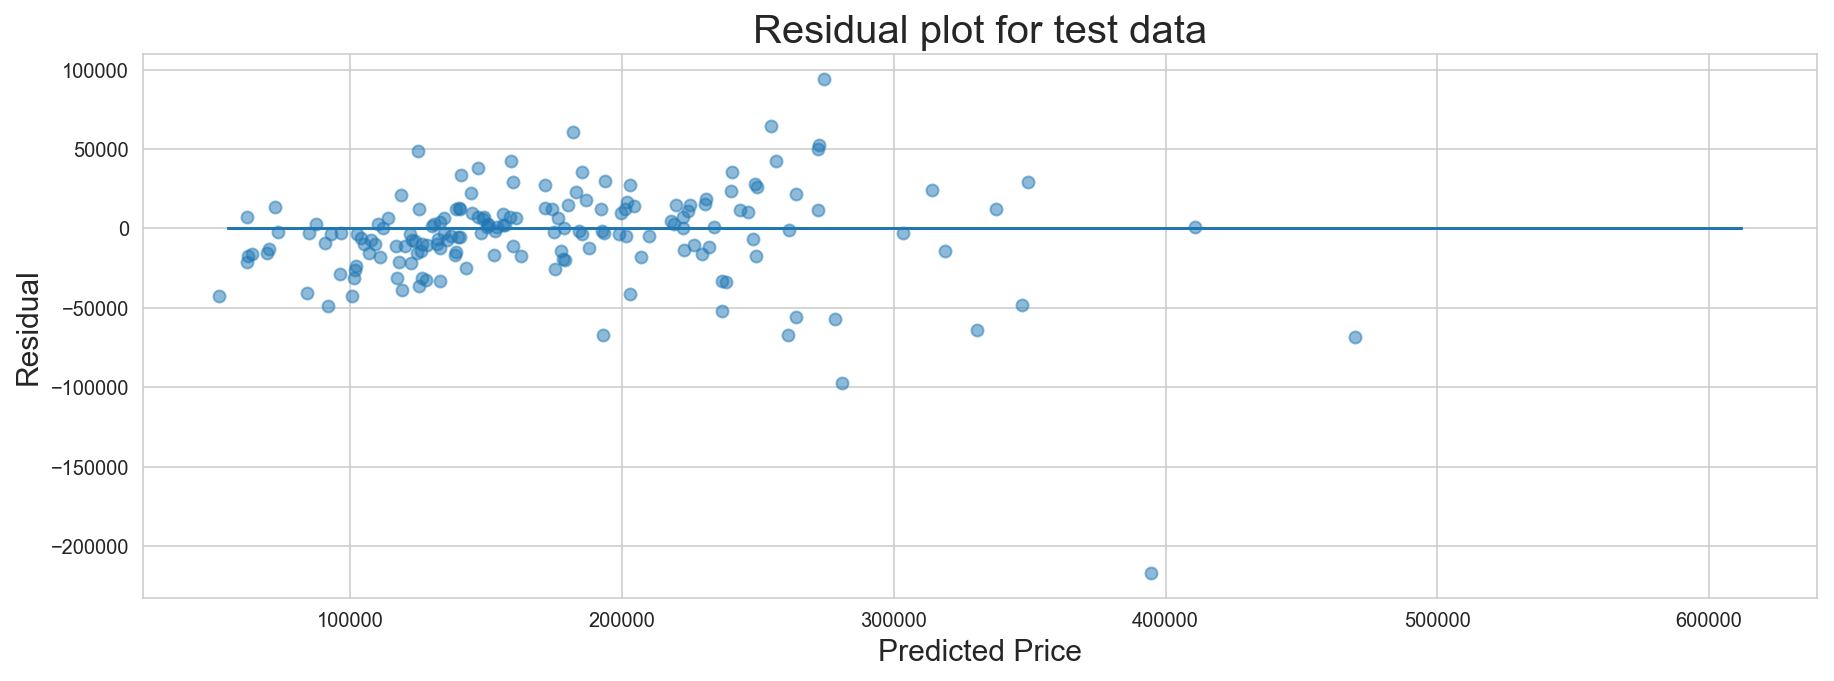

In [44]:
plt.figure(figsize=(15,5))
plt.scatter(house_test['price_predict'],house_test['residual'],alpha=0.5)
plt.plot(house_test['SalePrice'],[0 for val in house_test['SalePrice']])
plt.xlabel('Predicted Price', fontsize=15)
plt.ylabel('Residual', fontsize=15)
plt.title('Residual plot for test data', fontsize=20);

In [45]:
# Selected renovate-able columns

renovate_col = [
                'OverallQual',
                'OverallCond',
                'RoofStyle',
                'Exterior1st',
                'Exterior2nd',
                'MasVnrType',
                'ExterQual',
                'ExterCond',
                'Foundation',
                'BsmtQual',
                'BsmtCond',
                'HeatingQC',
                'Electrical',
                'KitchenQual',
                'FireplaceQu',
                'GarageFinish',
                'GarageQual',
                'GarageCond'
                ]

In [46]:
# Checking for null values

house[renovate_col].isnull().sum()

OverallQual     0
OverallCond     0
RoofStyle       0
Exterior1st     0
Exterior2nd     0
MasVnrType      0
ExterQual       0
ExterCond       0
Foundation      0
BsmtQual        0
BsmtCond        0
HeatingQC       0
Electrical      0
KitchenQual     0
FireplaceQu     0
GarageFinish    0
GarageQual      0
GarageCond      0
dtype: int64

In [47]:
# Checking for data types of the renovateable attributes

house[renovate_col].dtypes

OverallQual      int64
OverallCond      int64
RoofStyle       object
Exterior1st     object
Exterior2nd     object
MasVnrType      object
ExterQual       object
ExterCond       object
Foundation      object
BsmtQual        object
BsmtCond        object
HeatingQC       object
Electrical      object
KitchenQual     object
FireplaceQu     object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object

In [48]:
# Quick check on the distribution of all renovateable attributes

for col in house[renovate_col]:
    print(house.groupby(col).size())
    print("-"*100)

OverallQual
1       2
2       2
3      18
4     111
5     396
6     373
7     319
8     168
9      43
10     18
dtype: int64
----------------------------------------------------------------------------------------------------
OverallCond
1      1
2      4
3     24
4     54
5    819
6    250
7    204
8     72
9     22
dtype: int64
----------------------------------------------------------------------------------------------------
RoofStyle
Flat         13
Gable      1135
Gambrel      10
Hip         283
Mansard       7
Shed          2
dtype: int64
----------------------------------------------------------------------------------------------------
Exterior1st
AsbShng     19
AsphShn      1
BrkComm      2
BrkFace     49
CBlock       1
CemntBd     61
HdBoard    222
ImStucc      1
MetalSd    215
Plywood    107
Stone        2
Stucco      25
VinylSd    515
Wd Sdng    204
WdShing     26
dtype: int64
-------------------------------------------------------------------------------------------------

In [49]:
# Converting all string columns to meaningful values

# Training data (data prior 2010)

house_train.ExterQual.replace({'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},inplace=True)
house_train.BsmtQual.replace({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},inplace=True)

house_train.ExterCond.replace({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},inplace=True)
house_train.BsmtCond.replace({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},inplace=True)

house_train.HeatingQC.replace({'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},inplace=True)
house_train.KitchenQual.replace({'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},inplace=True)
house_train.FireplaceQu.replace({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},inplace=True)

house_train.GarageQual.replace({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},inplace=True)
house_train.GarageCond.replace({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},inplace=True)

# Test data (year 2010 data)

house_test.ExterQual.replace({'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},inplace=True)
house_test.BsmtQual.replace({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},inplace=True)

house_test.ExterCond.replace({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},inplace=True)
house_test.BsmtCond.replace({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},inplace=True)

house_test.HeatingQC.replace({'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},inplace=True)
house_test.KitchenQual.replace({'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},inplace=True)
house_test.FireplaceQu.replace({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},inplace=True)

house_test.GarageQual.replace({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},inplace=True)
house_test.GarageCond.replace({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},inplace=True)

C:\Users\swoo\Anaconda3\lib\site-packages\pandas\core\generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [50]:
# After data type processing - check data type again 
house_test[renovate_col].dtypes

OverallQual      int64
OverallCond      int64
RoofStyle       object
Exterior1st     object
Exterior2nd     object
MasVnrType      object
ExterQual        int64
ExterCond       object
Foundation      object
BsmtQual         int64
BsmtCond        object
HeatingQC        int64
Electrical      object
KitchenQual      int64
FireplaceQu      int64
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object

###  <font color=orange>Standardizing and dummifying X_train, y_train</font> 

In [51]:
Xr_train = house_train[renovate_col]
yr_train = house_train['residual']

renovate_col_cat = list(Xr_train.select_dtypes(include=['object']).columns)
renovate_col_num = list(Xr_train.select_dtypes(include=['int64']).columns)

Xrd_train = pd.get_dummies(Xr_train[renovate_col_cat],drop_first=True)
ss = StandardScaler()
Xrs_train = pd.DataFrame(ss.fit_transform(Xr_train[renovate_col_num]))
Xrs_train.columns = renovate_col_num
Xr_train_final = Xrs_train.merge(Xrd_train.reset_index(),how='left'\
                                 ,left_on = None, right_on = None, left_index = True, right_index = True)

C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### 2nd model : residuals ~ renovateable attributes
####  <font color=orange>Linear Regression</font>

In [52]:
linreg = LinearRegression()
linreg.fit(Xr_train_final,np.ravel(yr_train))
linreg_scores = cross_val_score(linreg, Xr_train_final,np.ravel(yr_train),cv=5)
print(linreg_scores)
print(np.mean(linreg_scores))

[0.05425757 0.04545377 0.05645168 0.0358592  0.00961529]
0.04032750289664018


####  <font color=orange>Ridge Regression</font>

In [53]:
ridge_alphas = np.logspace(-10, 10, 50)
ridge = RidgeCV(alphas=ridge_alphas, cv=5)
ridge_scores = cross_val_score(ridge, Xr_train_final,yr_train,cv=5)
ridge.fit(Xr_train_final,yr_train)
print(ridge_scores)
print(np.mean(ridge_scores))

C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.70855e-18): result may not be accurate.
  overwrite_a=True).T
C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.01518e-18): result may not be accurate.
  overwrite_a=True).T
C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.88627e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.01023e-18): result may not be accurate.
  overwrite_a=True).T
C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.72109e-18): result may not be accurate.
  overwrite_a=True).T
C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.p

C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.27546e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.70357e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.44218e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.07798e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-

C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.22754e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.43875e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.7246e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.32036e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-s

C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.96429e-18): result may not be accurate.
  overwrite_a=True).T
C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.37444e-18): result may not be accurate.
  overwrite_a=True).T
C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.70906e-18): result may not be accurate.
  overwrite_a=True).T
C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.47798e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=8.59837e-18): result may not be accurate.
  overwrite_a=True).T
C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.p

[0.14544755 0.0621659  0.11306444 0.09607062 0.04049047]
0.0914477973901934


####  <font color=orange>Lasso Regression</font>

In [54]:
lasso = LassoCV(cv=5)
lasso.fit(Xr_train_final,yr_train)
lasso_scores = cross_val_score(lasso,Xr_train_final,yr_train,cv=5)
print(lasso_scores)
print(np.mean(lasso_scores))

[0.14147059 0.06724143 0.10650513 0.09098842 0.03726586]
0.08869428376070483


####  <font color=orange>Lasso on Test Data</font>

In [55]:
Xr_test = house_test[renovate_col]
yr_test = house_test['residual']

renovate_col_cat = list(Xr_test.select_dtypes(include=['object']).columns)
renovate_col_num = list(Xr_test.select_dtypes(include=['int64']).columns)

Xrd_test = pd.get_dummies(Xr_test[renovate_col_cat],drop_first=True)
Xrs_test = pd.DataFrame(ss.fit_transform(Xr_test[renovate_col_num]))
Xrs_test.columns = renovate_col_num
Xr_test_final = Xrs_test.merge(Xrd_test.reset_index(),how='left'\
                               ,left_on = None, right_on = None, left_index = True, right_index = True)

missing_cols = set( Xr_train_final.columns ) - set( Xr_test_final.columns )

for c in missing_cols:
    Xr_test_final[c] = 0
    
Xr_test_final = Xr_test_final[Xr_train_final.columns]

C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [56]:
lasso.score(Xr_test_final,yr_test)

0.06379298712938541

In [57]:
lasso_reno_coefs = pd.DataFrame({'variable':Xr_train_final.columns,'coef':lasso.coef_,'abs_coef':np.abs(lasso.coef_)})
lasso_reno_coefs[lasso_reno_coefs['abs_coef']>0].sort_values('abs_coef',ascending=False).head(10)

variable          coef      abs_coef
17  Exterior1st_BrkFace -10212.025817  10212.025817
0           OverallQual  -6838.991524   6838.991524
1           OverallCond  -5403.447694   5403.447694
63     GarageFinish_RFn   4417.095304   4417.095304
61     Electrical_SBrkr   4220.602936   4220.602936
13        RoofStyle_Hip  -4025.258491   4025.258491
48    Foundation_CBlock  -2158.137269   2158.137269
7           FireplaceQu   1769.371221   1769.371221
46      MasVnrType_None  -1338.806231   1338.806231
2             ExterQual  -1323.351326   1323.351326

#### <font color=green> MODEL 2: residuals ~ renovateable_characteristics </font>

</font>
As the average R2 score from the models run are too low (between 0.04 to 0.08), the models give me low confidence that variances in predicted price and original saleprices can be explained just by the renovateable attributes. 

----

### MODEL 3: price ~ fixed + renovateable_characteristics 
A house's fixed characteristics play a crucial part in determining a property's base price, and typically that will also determines how much impact renovations will have on the property's value. 

In [58]:
# Renovateable attributes

renovate_col

# Fixed attributes

fixed_cat_col
corr_selected_feature

['house_age',
 'remod_years',
 'garage_age',
 'BsmtUnfSF',
 'BsmtFullBath',
 'LotArea',
 'HalfBath',
 '2ndFlrSF',
 'WoodDeckSF',
 'OpenPorchSF',
 'LotFrontage',
 'BsmtFinSF1',
 'BsmtExposure',
 'MasVnrArea',
 'Fireplaces',
 'TotRmsAbvGrd',
 'FullBath',
 '1stFlrSF',
 'TotalBsmtSF',
 'GarageArea',
 'GarageCars',
 'GrLivArea']

In [59]:
# Standardinzing and dummifying train data

Xf_train = house_train[fixed_cat_col + corr_selected_feature + renovate_col]
yf_train = pd.DataFrame(house_train['SalePrice'])

Xfd_train = pd.get_dummies(Xf_train[fixed_cat_col + renovate_col_cat],drop_first=True)

ss = StandardScaler()
Xfs_train = pd.DataFrame(ss.fit_transform(Xf_train[corr_selected_feature + renovate_col_num]))
Xfs_train.columns = corr_selected_feature + renovate_col_num

Xf_train_final = Xfs_train.merge(Xfd_train.reset_index()
                               ,how='left',left_on = None
                               , right_on = None
                               , left_index = True
                               , right_index = True)

C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [60]:
# Lasso

lasso = LassoCV(cv=5)
lasso.fit(Xf_train_final,np.ravel(yf_train))
lasso_scores = cross_val_score(lasso,Xf_train_final,np.ravel(yf_train),cv=5)
print(lasso_scores)
print(np.mean(lasso_scores))

[0.87336646 0.81322222 0.81053827 0.82476751 0.65087721]
0.794554335926366


In [61]:
# Ridge

ridge_alphas = np.logspace(-2, 7, 50)
ridge = RidgeCV(alphas=ridge_alphas, cv=10)
ridge_scores = cross_val_score(ridge, Xf_train_final,yf_train,cv=5)
ridge.fit(Xf_train_final,np.ravel(yf_train))
print(ridge_scores)
print(np.mean(ridge_scores))

C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\swoo\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[0.89301845 0.82763616 0.84320386 0.83098412 0.70037663]
0.8190438422397722


In [62]:
# Standardizing and dummifying test data

Xf_test = house_test[fixed_cat_col + corr_selected_feature + renovate_col]
yf_test = house_test['SalePrice']

Xfd_test = pd.get_dummies(Xf_test[fixed_cat_col + renovate_col_cat],drop_first=True)
Xfs_test = pd.DataFrame(ss.transform(Xf_test[corr_selected_feature + renovate_col_num]))
Xfs_test.columns = corr_selected_feature + renovate_col_num

Xf_test_final = Xfs_test.merge(Xfd_test.reset_index()
                             ,how='left'
                             ,left_on = None
                             ,right_on = None
                             ,left_index = True
                             ,right_index = True)

# Get missing columns for the test
missing_cols_f = set( Xf_train_final.columns ) - set( Xf_test_final.columns )

# Add a missing column in test set with default value equal to 0
for c in missing_cols_f:
    Xf_test_final[c] = 0
    
# Ensure the order of column in the test set is in the same order than in train set
Xf_test_final = Xf_test_final[Xf_train_final.columns]

C:\Users\swoo\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys


In [63]:
# Ridge on test data

ridge.score(Xf_test_final,yf_test)

0.8606649733327727

In [64]:
# Check for significant coefficients

ridge_coefs_f = pd.DataFrame({'variable':Xf_train_final.columns,'coef':ridge.coef_,'abs_coef':np.abs(ridge.coef_)})
ridge_coefs_f[ridge_coefs_f['abs_coef']>0].sort_values('abs_coef',ascending=False).head(10)

variable          coef      abs_coef
76  Neighborhood_NoRidge  25255.679283  25255.679283
77  Neighborhood_NridgHt  24542.706194  24542.706194
83  Neighborhood_StoneBr  19257.504387  19257.504387
22           OverallQual  15631.116050  15631.116050
21             GrLivArea  13818.181892  13818.181892
7               2ndFlrSF  12737.120971  12737.120971
68  Neighborhood_Edwards -11947.233284  11947.233284
36         MSSubClass_20  11776.619740  11776.619740
96        BldgType_Twnhs -11545.039703  11545.039703
97       BldgType_TwnhsE -10497.299853  10497.299853

In [65]:
house_test['OverallQual'].describe()

count    172.000000
mean       6.029070
std        1.313125
min        3.000000
25%        5.000000
50%        6.000000
75%        7.000000
max        9.000000
Name: OverallQual, dtype: float64

#### <font color=blue> Evaluate the effect in dollars of the renovate-able features. </font>

When the OverallQual increases by 1 point, the house value will increase an average of about 11k in price.
(Converted from the standard deviation (=1.3) of OverallQual)

#### <font color=blue> How would your company use this second model and its coefficients to determine whether they should buy a property or not? </font>

- Focusing on just top 10 coefficients of the model, we observe properties in the following neighborhood tend to have a higher impact on the price:
        - NoRidge
        - NridgHt
        - StoneBr
- Obviously property ground living areas and 2nd floor areas would impact property value significantly too.
- Interestingly building type like TwinHouses will have a negative impact the property price.

In order to determine whether my company should buy a company or not, we will use the informations at the next section to do so.

## <font color = green> Quick recap comparing the 3 models </font>
----
<font color = k> 
#### MODEL 1: price ~ fixed_characteristics 
</font>
 <br> Lasso gives an average R2 score of 0.79 on training data set. </br>
<br> When tested on test data, the R2 score is 0.85.</br>
<br> R-squared - a statistical measure of how close the data are to the fitted line.  Key limitations of R-squared: It can't determine whether the coefficient estiamtes and predictions are biased. In order to do that, we can look at our residual plot.</br>
----

<font color = k> 
#### MODEL 2: residuals ~ renovateable_characteristics 
</font>
As the average R2 score from the models run are too low (between 0.04 to 0.08), the models give me low confidence that variances in predicted price and original saleprices can be explained just by the renovateable attributes. 

----
<font color = k> 
#### MODEL 3: price ~ fixed_characteristics + renovateable_characteristics
</font>

A house's fixed characteristics play a crucial part in determining a property's base price, and typically that will also determines how much impact renovations will have on the property's value. A slight increase of R2 value is observed when renovateable attributes are included in the model.
[OverallQual] appears as one of the top 5 most significant coefficients in predicting property price.

----

## <font color = orange> Which property should the company buy or fix up? </font>

I will use the difference between the following prices to prioritze houses to buy or fix up:

- Original SalePrice
- Predicted Price on Fixed characteristics
- Predicted Price on Fixed + Reno characteristics

In [66]:
# calculating residuals for 3rd model using ridge model

house_train['price_predict_3'] = ridge.predict(Xf_train_final)
house_test['price_predict_3'] = ridge.predict(Xf_test_final)

house_train['residual_price_3_1'] = house_train['price_predict_3'] - house_train['price_predict']
house_test['residual_price_3_1'] = house_test['price_predict_3'] - house_test['price_predict']

C:\Users\swoo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\swoo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\swoo\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

C:\Users\swoo\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


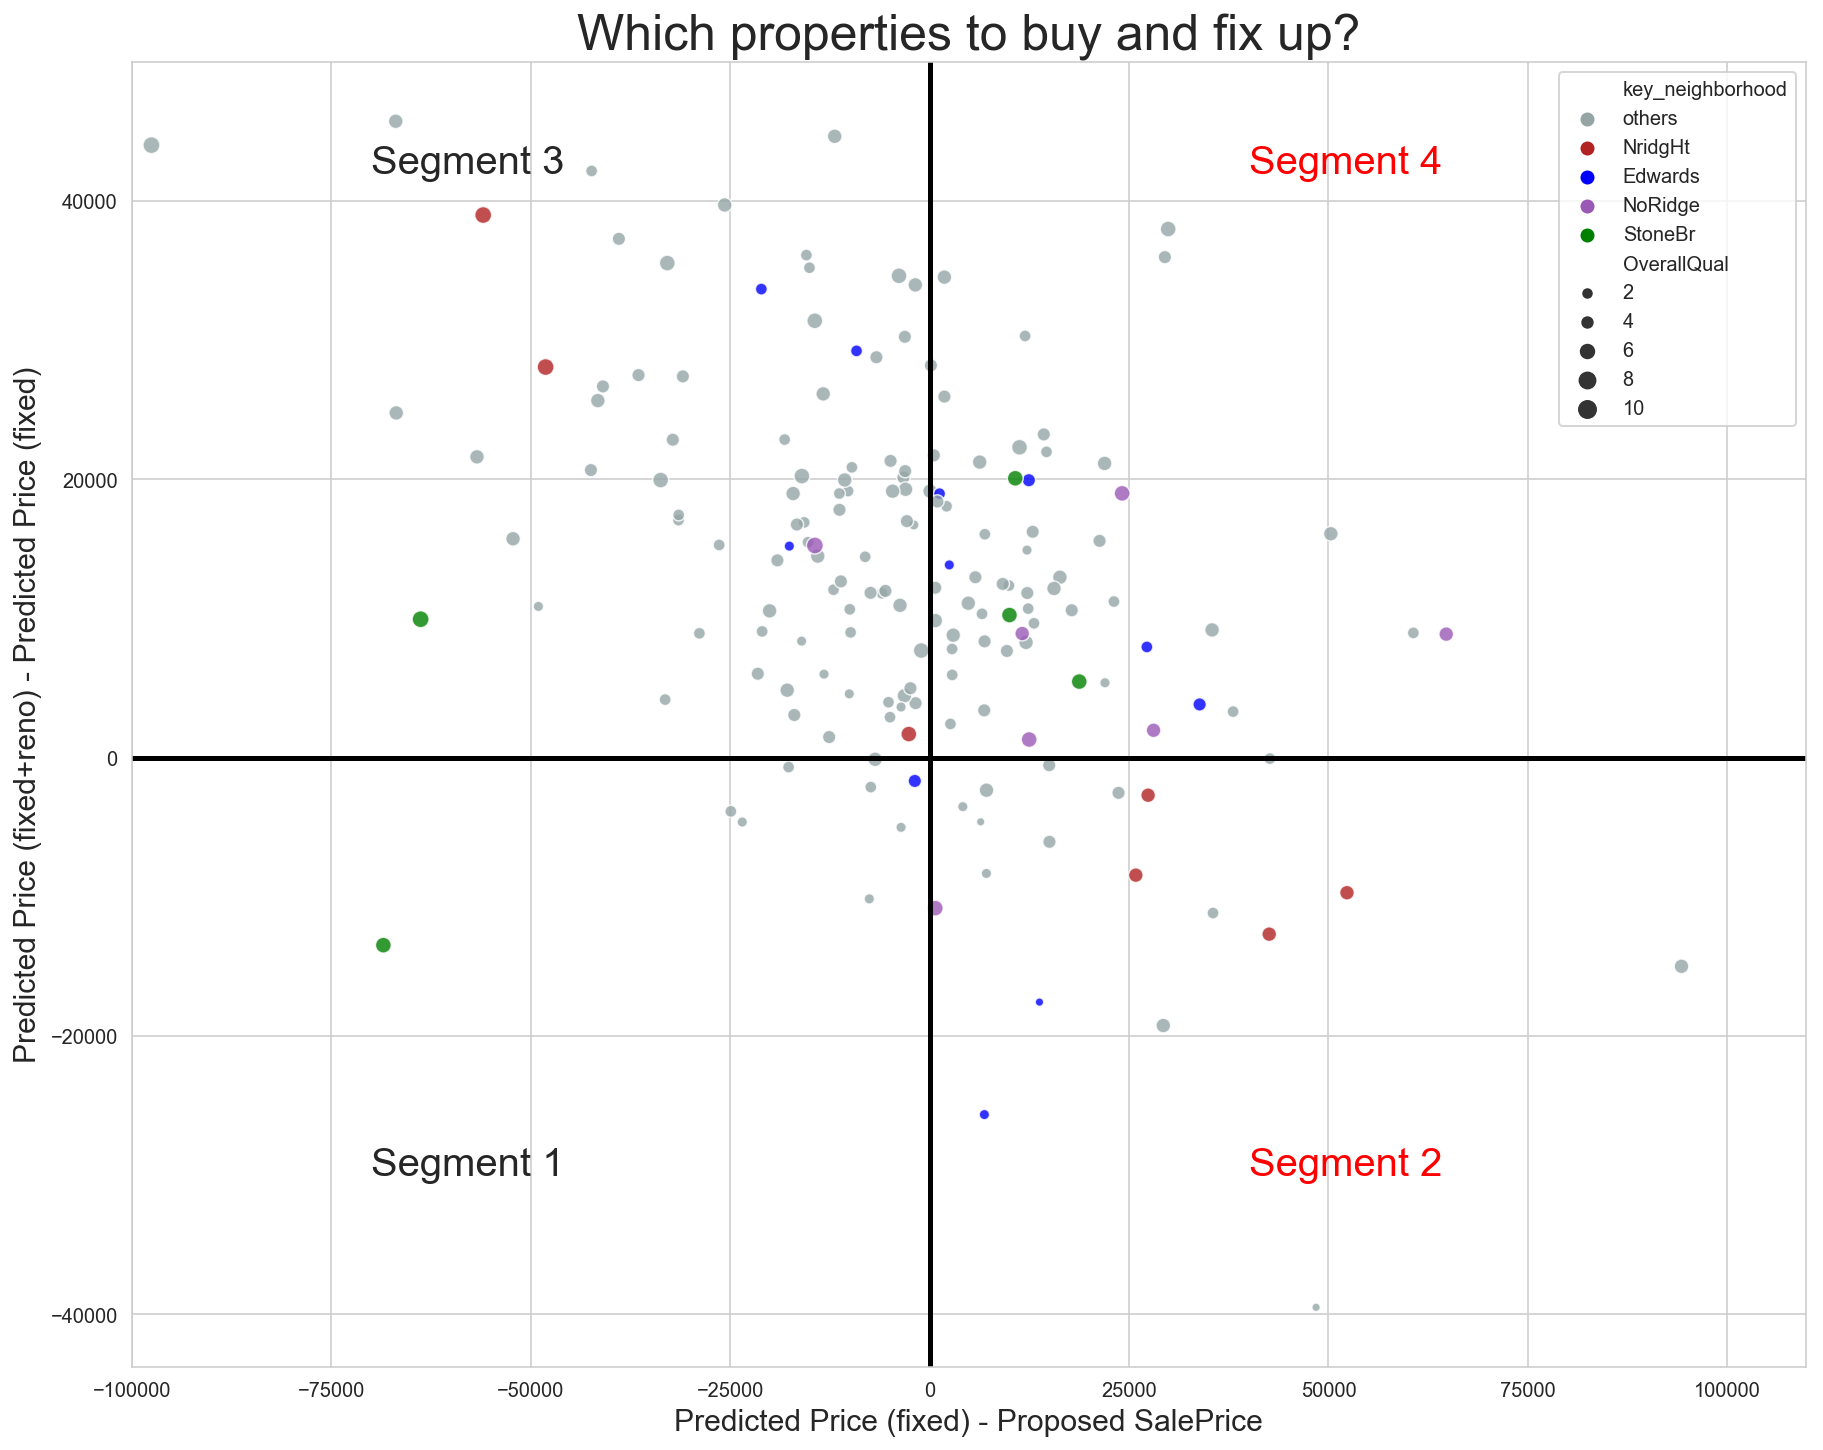

In [69]:
# Plotting a scatter plot comparing difference between:
# x-axis : Predicted price (fixed) - original saleprice
# y-axis : Predicted price (fixed + reno) - Predicted price (fixed)
from matplotlib import pyplot

plt.figure(figsize=(15,12))
sns.color_palette("husl", 5)
house_test['key_neighborhood'] = ['others' if val not in ['NoRidge','NridgHt','StoneBr','Edwards'] 
                                else val for val in house_test['Neighborhood']]

color = {'NoRidge':"#9b59b6",'NridgHt':"#B22222", 'StoneBr':"#008000", 'Edwards':"#0000FF", 'others':"#95a5a6"}

sns.scatterplot(data=house_test,x='residual',y='residual_price_3_1'
                ,hue='key_neighborhood',size="OverallQual"
                ,palette=color,alpha=0.8);

plt.xlim(-100000, None)
plt.xlabel('Predicted Price (fixed) - Proposed SalePrice',fontsize=15)
plt.ylabel('Predicted Price (fixed+reno) - Predicted Price (fixed)',fontsize=15)

plt.title('Which properties to buy and fix up?',fontsize=25);

pyplot.axvline(x=0,color='k',lw=2.5)
pyplot.axhline(y=0,color='k',lw=2.5)

ax = plt.gca()
ax.annotate('Segment 4', xy=(40000, 42000),fontsize=20,color='r')
ax.annotate('Segment 3', xy=(-70000, 42000),fontsize=20)
ax.annotate('Segment 2', xy=(40000, -30000),fontsize=20,color='r')
ax.annotate('Segment 1', xy=(-70000, -30000),fontsize=20);

## <font color = green> Explanation for chart above: </font>

I'm comparing properties using the prices below:
- Original SalePrice
- Predicted Price on Fixed characteristics
- Predicted Price on Fixed + Reno characteristics

Assuming that Original Saleprice would be the estimated saleprice put up by the owner on the platform, comparing to predicted price based on just fixed characteristics of the house:
- original saleprice < predicted saleprice ⮕ houses that are undervalued by the owners
        Segment 4 & Segment 2
        Investment opportunites for either the home buyer or investors
        

Which properties that the company should fix up?
- From 3rd model, we do observe that houses' qualities and conditions do impact house value.
        Properties in Segment 2 which has low qualities and conditions can be your prioritized segment to target at.


